# Geographic data in Python {#spatial-class}

## Introduction

This chapter introduces key Python packages and data structures for working with the two major types of spatial data, namely:

* **shapely** and **geopandas** --- for working with vector layers
* **rasterio** and **xarray** --- for working with rasters

As we will see in the code chunks presented later in this chapter, **shapely** and **geopandas** are related:

* **shapely** is a "low-level" package for working with individual vector geometry objects
* **geopandas** is a "high-level" package for working with geometry columns (`GeoSeries` objects), which internally contain **shapely** geometries, and vector layers (`GeoDataFrame` objects)

The **geopandas** ecosystem provides a comprehensive approach for working with vector layers in Python, with many packages building on it.
This is not the case for raster data, however: there are several partially overlapping packages for working with raster data, each with its own advantages and disadvantages. 
In this book we focus on the most prominent one:

* **rasterio** --- a spatial-oriented package, focused on "simple" raster formats (such as GeoTIFF), representing a raster using a combination of a `numpy` array, and a metadata object (`dict`) specifying the spatial referencing of the array

Another raster-related package worth mentioning is **xarray**. It is a general-purpose package for working with labeled arrays, thus advantageous for processing "complex" raster format (such as NetCDF), representing a raster using its own native classes, namely `xarray.Dataset` and `xarray.DataArray`

This chapter will briefly explain the fundamental geographic data models: vector and raster. 
Before demonstrating their implementation in Python, we will introduce the theory behind each data model and the disciplines in which they predominate.

The vector data model represents the world using points, lines, and polygons. 
These have discrete, well-defined borders, meaning that vector datasets usually have a high level of precision (but not necessarily accuracy).
<!-- , as we will see in Section ...). (TODO add section cross reference) -->
The raster data model divides the surface up into cells of constant size.
Raster datasets are the basis of background images used in web-mapping and have been a vital source of geographic data since the origins of aerial photography and satellite-based remote sensing devices.
Rasters aggregate spatially specific features to a given resolution, meaning that they are consistent over space and scalable (many worldwide raster datasets are available).

Which to use? The answer likely depends on your domain of application, and the datasets you have access to:

* Vector datasets and methods dominate the social sciences because human settlements and and processes (e.g. transport infrastructure) tend to have discrete borders
* Raster datasets and methods dominate many environmental sciences because of the reliance on remote sensing data

There is much overlap in some fields and raster and vector datasets can be used together: ecologists and demographers, for example, commonly use both vector and raster data. 
Furthermore, it is possible to convert between the two forms
<!-- TODO: (see Section ...).  -->
Whether your work involves more use of vector or raster datasets, it is worth understanding the underlying data models before using them, as discussed in subsequent chapters. 
This book focusses on approaches that build on **geopandas** and **rasterio** packages to work with vector data and raster datasets, respectively.

## Vector data

The geographic vector data model is based on points located within a coordinate reference system (CRS). 
Points can represent self-standing features (e.g., the location of a bus stop), or they can be linked together to form more complex geometries such as lines and polygons. 
Most point geometries contain only two dimensions (3-dimensional CRSs contain an additional $z$ value, typically representing height above sea level).

In this system, London, for example, can be represented by the coordinates `(-0.1, 51.5)`. 
This means that its location is -0.1 degrees east and 51.5 degrees north of the origin.
The origin, in this case, is at 0 degrees longitude (the Prime Meridian) and 0 degree latitude (the Equator) in a geographic ('lon/lat') CRS.
<!-- TODO: (Figure ..., left panel). -->
The same point could also be approximated in a projected CRS with 'Easting/Northing' values of `(530000, 180000)` in the British National Grid, meaning that London is located 530 $km$ East and 180 $km$ North of the origin of the CRS. 
<!-- This can be verified visually: slightly more than 5 'boxes' --- square areas bounded by the gray grid lines 100 $km$ in width --- separate the point representing London from the origin. -->
<!-- TODO: (Figure 2.1, right panel). -->
The location of National Grid's origin, in the sea beyond South West Peninsular, ensures that most locations in the UK have positive Easting and Northing values.

<!-- There is more to CRSs, as described in Sections ... and ... but, for the purposes of this section, it is sufficient to know that coordinates consist of two numbers representing the distance from an origin, usually in $x$ then $y$ dimensions.

...
FIGURE ...: Illustration of vector (point) data in which location of London (the red X) is represented with reference to an origin (the blue circle). 
The left plot represents a geographic CRS with an origin at 0° longitude and latitude. 
The right plot represents a projected CRS with an origin located in the sea west of the South West Peninsula. -->

**geopandas** provides classes for geographic vector data and a consistent command-line interface for reproducible geographic data analysis in Python.
**geopandas** provides an interface to three mature libraries for geocomputation which, in combination, represent a strong foundation on which many geographic applications (including QGIS and R's spatial ecosystem) builds:

*  GDAL, for reading, writing, and manipulating a wide range of geographic data formats, covered in Chapter 8
*  PROJ, a powerful library for coordinate system transformations, which underlies the content covered in Chapter 7
*  GEOS, a planar geometry engine for operations such as calculating buffers and centroids on data with a projected CRS, covered in Chapter 5

Tight integration with these geographic libraries makes reproducible geocomputation possible: an advantage of using a higher level language such as Python to access these libraries is that you do not need to know the intricacies of the low level components, enabling focus on the methods rather than the implementation.
This section introduces **geopandas** classes in preparation for subsequent chapters (Chapters 5 and 8 cover the GEOS and GDAL interface, respectively).

### Vector data classes

The main classes for working with geographic vector data in Python are hierarchical, meaning the highest level 'vector layer' class is composed of simpler 'geometry column' and individual 'geometry' components.
This section introduces them in order, starting with the highest level class.
For many applications, the high level vector layer class, which are essentially data frame with geometry columns, are that's needed.
However, it's important to understand the structure of vector geographic objects and their component pieces for more advanced applications.
The three main vector geographic data classes in Python are:

* `GeoDataFrame`, a class representing vector layers, with a geometry column (class `GeoSeries`) as one of the columns
* `GeoSeries`, a class that is used to represent the geometry column in `GeoDataFrame` objects
* `shapely` objects which represent individual geometries such as a point or a polygon

The first two classes (`GeoDataFrame` and `GeoSeries`) are defined in **geopandas**.
The third class is defined in the **shapely** package, which deals with individual geometries, and is a main dependency of the **geopandas** package.

### Vector layers {#sec-vector-layers}

The most commonly used geographic vector data structure is the vector layer.
There are several approaches for working with vector layers in Python, ranging from low-level packages (e.g., **osgeo**, **fiona**) to the relatively high-level **geopandas** package that is the focus of this section.
Before writing and running code for creating and working with geographic vector objects, we therefore import **geopandas** (by convention as `gpd` for more concise code) and **shapely**:

In [1]:
import geopandas as gpd
import shapely.geometry
import shapely.wkt

We also limit the maximum number of printed rows to four, to save space, using the `'display.max_rows'` option of **pandas**:

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 4)

Projects often start by importing an existing vector layer saved as an ESRI Shapefile (`.shp`), a GeoPackage (`.gpkg`) file, or other geographic file format.
The function `read_file()` in the following line of code imports a GeoPackage file named `world.gpkg` located in the `data` directory of Python's working directory into a `GeoDataFrame` named `gdf`:

In [3]:
#| echo: false
#| label: getdata
from pathlib import Path
import os
import shutil
data_path = Path('data')
if data_path.is_dir():
  pass
  # print('path exists') # directory exists
else:
  print('Attempting to get and unzip the data')
  import requests, zipfile, io
  r = requests.get('https://github.com/geocompr/py/releases/download/0.1/data.zip')
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall('.')
data_path = Path('data/cycle_hire_osm.gpkg')
if data_path.is_file():
  pass
  # print('path exists') # directory exists
else:
  print('Attempting to move data')
  r = requests.get('https://github.com/geocompr/py/archive/refs/heads/main.zip')
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall('.')
  shutil.copytree('py-main/data', 'data', dirs_exist_ok=True) 
data_path = Path('output')
if data_path.is_dir():
  pass
  # print('path exists') # directory exists
else:
  print('Attempting to move data')
  shutil.copytree('py-main/output', 'output', dirs_exist_ok=True) 

In [4]:
gdf = gpd.read_file('data/world.gpkg')

As  result is an object of type (class) `GeoDataFrame` with 177 rows (features) and 11 columns, as shown in the output of the following code chunk:

In [5]:
#| label: typegdf
type(gdf)
gdf.shape

(177, 11)

The `GeoDataFrame` class is an extension of the `DataFrame` class from the popular **pandas** package. 
This means we can treat a vector layer as a table, and process it using the ordinary, i.e., non-spatial, established function methods.
For example, standard data frame subsetting methods can be used.
The code below creates a subset of the `gdf` dataset containing only the country name and the geometry:

In [6]:
gdf = gdf[['name_long', 'geometry']]
gdf

,name_long,geometry
0,Fiji,"MULTIPOLYGON (((-180.00000 -16.55522, -179.917..."
1,Tanzania,"MULTIPOLYGON (((33.90371 -0.95000, 31.86617 -1..."
...,...,...
175,Trinidad and Tobago,"MULTIPOLYGON (((-61.68000 10.76000, -61.66000 ..."
176,South Sudan,"MULTIPOLYGON (((30.83385 3.50917, 31.24556 3.7..."


The following expression creates a subset based on a condition, such as equality of the `'name_long'` column to the string `'Egypt'`:

In [7]:
gdf[gdf['name_long'] == 'Egypt']

,name_long,geometry
163,Egypt,"MULTIPOLYGON (((36.86623 22.00000, 36.69069 22..."


Finally, to get a sense of the spatial component of the vector layer, it can be plotted using the `.plot` method, as follows:

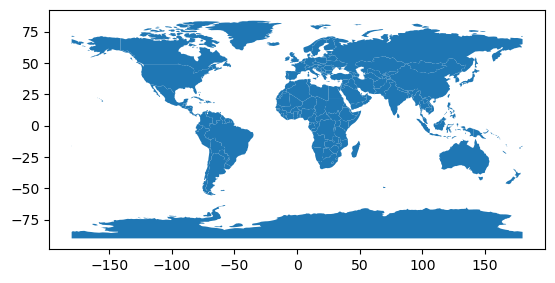

In [8]:
gdf.plot();

or using `.explore` to get an interactive plot:

In [9]:
gdf.explore()

In [10]:
#| echo: false
# (Alternative)
# import hvplot.pandas
# gdf.hvplot(title='Hello world', geo=True, hover_cols=['name_long'], legend=False).opts(bgcolor='lightgray', active_tools=['wheel_zoom']) 
#This way, we can also add background tiles:
# gdf.hvplot(tiles='OSM', alpha=0.5, geo=True, title='Hello world', hover_cols=['name_long'], legend=False).opts(active_tools=['wheel_zoom']) 

### Geometry columns {#sec-geometry-columns}

A vital column in a `GeoDataFrame` is the geometry column, of class `GeoSeries`.
The geometry column contains the geometric part of the vector layer.
In the case of the `gdf` object, the geometry column contains `'MultiPolygon'`s  associated with each country:

In [11]:
gdf['geometry']

0      MULTIPOLYGON (((-180.00000 -16.55522, -179.917...
1      MULTIPOLYGON (((33.90371 -0.95000, 31.86617 -1...
                             ...                        
175    MULTIPOLYGON (((-61.68000 10.76000, -61.66000 ...
176    MULTIPOLYGON (((30.83385 3.50917, 31.24556 3.7...
Name: geometry, Length: 177, dtype: geometry

The geometry column also contains the spatial reference information, if any.

Many geometry operations, such as calculating the centroid, buffer, or bounding box of each feature involve just the geometry.
Applying this type of operation on a `GeoDataFrame` is therefore basically a shortcut to applying it on the `GeoSeries` object in the geometry column.
The two following commands therefore return exactly the same result, a `GeoSeries` with country centroids:

In [12]:
gdf.centroid

/tmp/ipykernel_174627/2017122361.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid


0      POINT (163.85312 -17.31631)
1        POINT (34.75299 -6.25773)
                  ...             
175     POINT (-61.33037 10.42824)
176       POINT (30.19862 7.29289)
Length: 177, dtype: geometry

In [13]:
gdf['geometry'].centroid

/tmp/ipykernel_174627/3996546279.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'].centroid


0      POINT (163.85312 -17.31631)
1        POINT (34.75299 -6.25773)
                  ...             
175     POINT (-61.33037 10.42824)
176       POINT (30.19862 7.29289)
Length: 177, dtype: geometry

<!-- Note: the attribute data is lost in the first example, right? Worth stating that? (RL 2022-07) -->

Another useful property of the geometry column is the geometry type, as shown in the following code chunk. 
Note that the types of geometries contained in a geometry column (and, thus, a vector layer) are not necessarily the same.
Accordingly, the `.type` property returns a `Series` (of type `string`), rather than a single value:

In [14]:
gdf['geometry'].type

0      MultiPolygon
1      MultiPolygon
           ...     
175    MultiPolygon
176    MultiPolygon
Length: 177, dtype: object

To summarize the occurrence of different geometry types in a geometry column, we can use the **pandas** method called `value_counts`:

In [15]:
gdf['geometry'].type.value_counts()

MultiPolygon    177
dtype: int64

In this case, we see that the `gdf` layer contains only `'MultiPolygon'` geometries.
It is possible to have multiple geometry types in a single `GeoDataFrame`.

### The Simple Features standard

Geometries are the basic building blocks of vector layers. 
Although the Simple Features standard defines about 20 types of geometries, we will focus on the seven most commonly used types: `POINT`, `LINESTRING`, `POLYGON`, `MULTIPOINT`, `MULTILINESTRING`, `MULTIPOLYGON` and `GEOMETRYCOLLECTION`. 
Find the whole list of possible feature types in the PostGIS manual.
<!-- TODO: add a hyperlink -->

Well-known binary (WKB) and well-known text (WKT) are the standard encodings for simple feature geometries.
<!-- TODO: add reference or at least link to OGC document on this? -->
WKB representations are usually hexadecimal strings easily readable for computers. 
This is why GIS and spatial databases use WKB to transfer and store geometry objects. 
WKT, on the other hand, is a human-readable text markup description of simple features.
Both formats are exchangeable, and if we present one, we will naturally choose the WKT representation.

The foundation of each geometry type is the point. 
A point is simply a coordinate in 2D, 3D, or 4D space such as:
<!-- TODO: (see the left panel in Figure ...): -->

```text
POINT (5 2)
```

A linestring is a sequence of points with a straight line connecting the points, for example:
<!-- TODO: (see middle panel in Figure ...): -->

```text
LINESTRING (1 5, 4 4, 4 1, 2 2, 3 2)
```

A polygon is a sequence of points that form a closed, non-intersecting ring. Closed means that the first and the last point of a polygon have the same coordinates (see right panel in Figure ...).

```text
POLYGON ((1 5, 2 2, 4 1, 4 4, 1 5))
```

<!-- TODO: Illustration of point, linestring and polygon geometries...
FIGURE ...: Illustration of point, linestring and polygon geometries... -->

So far we have created geometries with only one geometric entity per feature. 
However, the Simple Features standard allows multiple geometries to exist within a single feature, using "multi" versions of each geometry type, as illustrated below:

```text
MULTIPOINT (5 2, 1 3, 3 4, 3 2)
MULTILINESTRING ((1 5, 4 4, 4 1, 2 2, 3 2), (1 2, 2 4))
MULTIPOLYGON (((1 5, 2 2, 4 1, 4 4, 1 5), (0 2, 1 2, 1 3, 0 3, 0 2)))
```

<!-- TODO: Illustration of multi* geometries...
FIGURE ...: Illustration of multi* geometries... -->

Finally, a geometry collection can contain any combination of geometries including (multi)points and linestrings:
<!-- TODO: (see Figure ...): -->

```text
GEOMETRYCOLLECTION (MULTIPOINT (5 2, 1 3, 3 4, 3 2), LINESTRING (1 5, 4 4, 4 1, 2 2, 3 2))
```

### Geometries {#sec-geometries}

Each element in the geometry column is a geometry object, of class `shapely`.
For example, here is one specific geometry selected by implicit index (that of Canada):

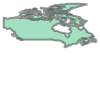

In [16]:
gdf['geometry'].iloc[3]

We can also select a specific geometry based on the `'name_long'` attribute:

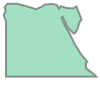

In [17]:
gdf[gdf['name_long'] == 'Egypt']['geometry'].iloc[0]

The **shapely** package is compatible with the Simple Features standard.
Accordingly, seven types of geometries are supported.
The following section demonstrates creating a `shapely` geometry of each type from scratch. In the first example (a `'Point'`) we demonstrate two types of inputs for geometry creation:

* a list of coordinates
* a `string` in the WKT format and 

In the examples for the remaining geometries we use the former approach.

Creating a `'Point'` geometry from a list of coordinates uses the `shapely.geometry.Point` function:

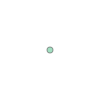

In [18]:
point = shapely.geometry.Point(5, 2)
point

Alternatively, we can use the `shapely.wkt.loads` (stands for "load a WKT *s*tring") to transform a WKT string to a `shapely` geometry object. 
Here is an example of creating the same `'Point'` geometry from WKT:

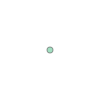

In [19]:
point = shapely.wkt.loads('POINT (5 2)')
point

Here is an example of a `'MultiPoint'` geometry:

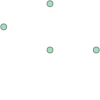

In [20]:
multipoint = shapely.geometry.MultiPoint([(5,2), (1,3), (3,4), (3,2)])
multipoint

Here is an example of a `'LineString'` geometry:

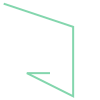

In [21]:
linestring = shapely.geometry.LineString([(1,5), (4,4), (4,1), (2,2), (3,2)])
linestring

Here is an example of a `'MultiLineString'` geometry:

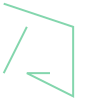

In [22]:
linestring = shapely.geometry.MultiLineString([[(1,5), (4,4), (4,1), (2,2), (3,2)], [(1,2), (2,4)]])
linestring

Here is an example of a `'Polygon'` geometry:

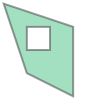

In [23]:
polygon = shapely.geometry.Polygon([(1,5), (2,2), (4,1), (4,4), (1,5)], [[(2,4), (3,4), (3,3), (2,3), (2,4)]])
polygon

Here is an example of a `'MultiPolygon'` geometry:

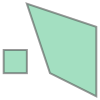

In [24]:
multipolygon = shapely.geometry.MultiPolygon([
    shapely.geometry.Polygon([(1,5), (2,2), (4,1), (4,4), (1,5)]), 
    shapely.geometry.Polygon([(0,2), (1,2), (1,3), (0,3), (0,2)])
])
multipolygon

And, finally, here is an example of a `'GeometryCollection'` geometry:

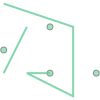

In [25]:
multipoint = shapely.geometry.GeometryCollection([
    shapely.geometry.MultiPoint([(5,2), (1,3), (3,4), (3,2)]),
    shapely.geometry.MultiLineString([[(1,5), (4,4), (4,1), (2,2), (3,2)], [(1,2), (2,4)]])
])
multipoint

`shapely` geometries act as atomic units of vector data, as spatial operations on a geometry return a single new geometry.
For example, the following expression calculates the difference between the buffered `multipolygon` (using distance of `0.2`) and itself:

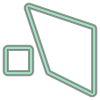

In [26]:
multipolygon.buffer(0.2).difference(multipolygon)

As demonstrated above, a `shapely` geometry object is automatically evaluated to a small image of the geometry (when using an interface capable of displaying it, such as a Jupyter Notebook). 
To print the WKT string instead, we can use the `print` function:

In [27]:
print(linestring)

MULTILINESTRING ((1 5, 4 4, 4 1, 2 2, 3 2), (1 2, 2 4))


We can determine the geometry type using the `.geom_type` property, which returns a `string`:

In [28]:
linestring.geom_type

'MultiLineString'

Finally, it is important to note that raw coordinates of `shapely` geometries are accessible through a combination of the `.coords`, `.geoms`, `.exterior`, and `.interiors`, properties (depending on the geometry type). 
These access methods are helpful when we need to develop our own spatial operators for specific tasks. 
For example, the following expression returns the coordinates of the `polygon` geometry exterior (note that the returned object is iterable, thus enclosed in a `list` to return all coordinates at once):

In [29]:
list(polygon.exterior.coords)

[(1.0, 5.0), (2.0, 2.0), (4.0, 1.0), (4.0, 4.0), (1.0, 5.0)]

### Vector layer from scratch

In the previous sections we started with a vector layer (`GeoDataFrame`), from an existing Shapefile, and "decomposed" it to extract the geometry column (`GeoSeries`, @sec-geometry-columns) and separate geometries (`shapely`, see @sec-geometries).
In this section we will demonstrate the opposite process, constructing a `GeoDataFrame` from `shapely` geometries, combined into a `GeoSeries`.
This will:

* help you better understand the structure of a `GeoDataFrame`, and
* may come in handy when you will need to programmatically construct simple vector layers, such as a line between two given points, etc.

Vector layers consist of two main parts: geometries and non-geographic attributes. Figure ... shows how a `GeoDataFrame` object is created – geometries come from a `GeoSeries` object, while attributes are taken from `Series` objects. 

(Figure such as https://geocompr.robinlovelace.net/spatial-class.html#fig:02-sfdiagram)

Non-geographic attributes represent the name of the feature or other attributes such as measured values, groups, and other things. To illustrate attributes, we will represent a temperature of 25°C in London on June 21st, 2017. This example contains a geometry (the coordinates), and three attributes with three different classes (place name, temperature and date). Objects of class `GeoDataFrame` represent such data by combining the attributes (`Series`) with the simple feature geometry column (`GeoSeries`). First, we create a point geometry, which we know how to do from @sec-geometries:

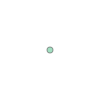

In [30]:
lnd_point = shapely.geometry.Point(0.1, 51.5)
lnd_point

Next, we create a `GeoSeries` (of length 1), containing the point. Note that a `GeoSeries` stores a CRS definition, in this case WGS84 (defined using its EPSG code `4326`). Also note that the `shapely` geometries go into a `list`, to illustrate that there can be more than one (unlike in this example):

In [31]:
lnd_geom = gpd.GeoSeries([lnd_point], crs = 4326)
lnd_geom

0    POINT (0.10000 51.50000)
dtype: geometry

Next, we combine the `GeoSeries` with other attributes into a `dict`. The geometry column is a `GeoSeries`, named `geometry`. The other attributes (if any) may be defined using `list` or `Series` objects. Here, for simplicity, we use the `list` option for defining the three attributes `name`, `temperature`, and `date`. Again, note that the `list` can be of length >1, in case we are creating a layer with more than one feature:

In [32]:
d = {
  'name': ['London'],
  'temperature': [25],
  'date': ['2017-06-21'],
  'geometry': lnd_geom
}

Finally, the `dict` can be coverted to a `GeoDataFrame`:

In [33]:
lnd_layer = gpd.GeoDataFrame(d)
lnd_layer

,name,temperature,date,geometry
0,London,25,2017-06-21,POINT (0.10000 51.50000)


What just happened? First, the coordinates were used to create the simple feature geometry (`shapely`). Second, the geometry was converted into a simple feature geometry column (`GeoSeries`), with a CRS. Third, attributes were combined with `GeoSeries`. This results in an `GeoDataFrame` object, named `lnd_layer`.

Just to illustrate how does creating a layer with more than one feature looks like, here is an example where we create a layer with two points, London and Paris:

In [34]:
lnd_point = shapely.geometry.Point(0.1, 51.5)
paris_point = shapely.geometry.Point(2.3, 48.9)
towns_geom = gpd.GeoSeries([lnd_point, paris_point], crs = 4326)
d = {
  'name': ['London', 'Paris'],
  'temperature': [25, 27],
  'date': ['2017-06-21', '2017-06-21'],
  'geometry': towns_geom
}
towns_layer = gpd.GeoDataFrame(d)
towns_layer

,name,temperature,date,geometry
0,London,25,2017-06-21,POINT (0.10000 51.50000)
1,Paris,27,2017-06-21,POINT (2.30000 48.90000)


The following expression creates an interactive map with the result:

In [35]:
towns_layer.explore()

## Raster data

### Introduction

As mentioned above, working with rasters in Python is less organized around one comprehensive package (compared to the case for vector layers and **geopandas**).
Instead, several packages provide alternative subsets of method for working with raster data. 

The two most notable approaches for working with rasters in Python are provided by the **rasterio** and **xarray** packages.
As we will see shortly, they differ in their scope and underlying data models. 
Specifically, **rasterio** represents rasters as **numpy** arrays associated with a separate object holding the spatial metadata.
The **xarray** package, however, represents rasters with the native `DataArray` object, which is an extension of **numpy** array designed to hold axis labels and attributes, in the same object, together with the array of raster values.

Both packages are not exhaustive in the same way as **geopandas** is. 
For example, when working with **rasterio**, on the one hand, more packages may be needed to accomplish common tasks such as zonal statistics (package **rasterstats**) or calculating topographic indices (package **richdem**). 
On the other hand, **xarray** was extended to accommodate spatial operators missing from the core package itself, with the **rioxarray** and **xarray-spatial** packages.

In the following two sections, we introduce the **rasterio**, which is the raster-related package we are going to work with through the rest of the book. 

### Using **rasterio** {#sec-using-rasterio}

To work with the **rasterio** package, we first need to import it.
We also import **numpy**, since the underlying raster data are stored in **numpy** arrays.
To effectively work with those, we expose all **numpy** functions.
Finally, we import the `show` function from the `rasterio.plot` sub-module for quick visualization of rasters.

In [36]:
import numpy as np
import rasterio
from rasterio.plot import show
import subprocess

Rasters are typically imported from existing files.
When working with **rasterio**, importing a raster is actually a two-step process:

* First, we open a raster file "connection" using `rasterio.open`
* Second, we read raster values from the connection using the `.read` method

This separation is analogous to basic Python functions for reading from files, such as `open` and `.readline` to read from a text file.
The rationale is that we do not always want to read all information from the file into memory, which is particularly important as rasters size can be larger than RAM size. 
Accordingly, the second step (`.read`) is selective. For example, we may want to read just one raster band rather than reading all bands.

In the first step, we pass a file path to the `rasterio.open` function to create a file connection. 
For this example, we use a single-band raster representing elevation in Zion National Park:

In [37]:
src = rasterio.open('data/srtm.tif')

To get a first impression of the raster values, we can plot it using the `show` function:

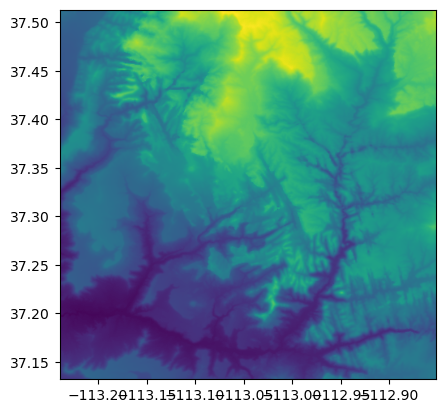

In [38]:
show(src);

The "connection" object contains the raster metadata, that is, all of the information other than the raster values.
Let us examine it:

In [39]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

Importantly, we can see: 

* The raster data type (`dtype`)
* Raster dimensions (`width`, `height`, and `count`, i.e., number of layers)
* Raster Coordinate Reference System (`crs`)
* The raster affine transformation matrix (`transform`)

The last item (i.e., `transform`) deserves more attention. 
To position a raster in geographical space, in addition to the CRS we must specify the raster *origin* ($x_{min}$, $y_{max}$) and resolution ($delta_{x}$, $delta_{y}$). 
In the transform matrix notation, these data items are stored as follows:

```{text}
Affine(delta_x, 0.0, x_min,
       0.0, delta_y, y_max)
```

Note that, by convention, raster y-axis origin is set to the maximum value ($y_{max}$) rather than the minimum, and, accordingly, the y-axis resolution ($delta_{y}$) is negative. 

The `.read` method of a raster file connection object is used to read the last but not least piece of information: the raster values.
Importantly, we can read:

* A particular layer, passing a numeric index (as in `.read(1)`)
* A subset of layers, passing a `list` of indices (as in `.read([1,2])`)
* All layers (as in `.read()`)

Note that the layer indices start from `1`, contrary to the Python convention of the first index being `0`. 

The resulting object is a **numpy** array, with either two or three dimensions:

* *Three* dimensions, when reading more than one layer (e.g., `.read()` or `.read([1,2])`). 
In such case, the dimensions pattern is `(layers, rows, columns)`
* *Two* dimensions, when reading one specific layer (e.g., `.read(1)`)

Let's read the first (and only) layer from the `srtm.tif` raster, using the file connection object `src`, for example:

In [40]:
s = src.read(1)
s

array([[1728, 1718, 1715, ..., 2654, 2674, 2685],
       [1737, 1727, 1717, ..., 2649, 2677, 2693],
       [1739, 1734, 1727, ..., 2644, 2672, 2695],
       ...,
       [1326, 1328, 1329, ..., 1777, 1778, 1775],
       [1320, 1323, 1326, ..., 1771, 1770, 1772],
       [1319, 1319, 1322, ..., 1768, 1770, 1772]], dtype=uint16)

The result `s` is a two-dimensional `numpy` array.

### Raster from scratch

In this section, we are going to demonstrate creation of rasters from scratch. We are going to create two small rasters, `elev` and `grain`, which we are going to use in examples later on in the book. Unlike creating a vector layer, creating a raster from scratch is rarely needed in practive because aligning a raster with the right spatial extent is difficult to do programmatically (GIS software is a better fit for the job). Nevertheless, the examples will be useful to become more familiar with the `rasterio` data structures.

A raster is basically an array combined with georeferencing information, namely:

* A transformation matrix (linking pixel indices with coordinates)
* A CRS definition

Therefore, to create a raster, we first need to have an array with the values, then supplement it with the georeferencing information. Let's create the arrays `elev` and `grain`. The `elev` array is a 6 by 6 array with sequential values from 1 to 36. It can be created as follows:

In [54]:
elev = np.arange(1, 37, dtype=np.uint8).reshape(6, 6)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

The `grain` array represents a categorical raster with values `0`, `1`, `2`, corresponding to categories "clay", "silt", "sand", respectively. We will create if from a specific arrangement of pixel values, as follows:

In [53]:
v = [1, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 2]
grain = np.array(v, dtype=np.uint8).reshape(6, 6)
grain

array([[1, 0, 1, 2, 2, 2],
       [0, 2, 0, 0, 2, 1],
       [0, 2, 2, 0, 0, 2],
       [0, 0, 1, 1, 1, 1],
       [1, 1, 1, 2, 1, 1],
       [2, 1, 2, 2, 0, 2]], dtype=uint8)

Note that in both cases we are using the `uint8` (unsigned integer in 8 bits, i.e., `0-255`) data type, which is minimally sufficient to represent all possible values of the given rasters. This is the recommended approach for a minimal memory footprint.

What is missing is the raster transform (see @sec-using-rasterio). In this case, since the rasters are arbitrary, we also set up an arbitrary transformation matrix, where:

* the origin ($x_{min}$, $y_{max}$) is at `-1.5,1.5`, and
* and resolution ($delta_{x}$, $delta_{y}$) is `0.5,-0.5`.

In terms of code, we do that as follows, using `rasterio.transform.from_origin`:

In [60]:
new_transform = rasterio.transform.from_origin(west=-1.5, north=1.5, xsize=0.5, ysize=0.5)
new_transform

Affine(0.5, 0.0, -1.5,
       0.0, -0.5, 1.5)

Note that, confusingly, $delta_{y}$ is defined in `rasterio.transform.from_origin` using a positive value (`0.5`), even though it is eventuially negative (`-0.5`)! 

The raster can now be protted in its coordinate system, passing the array along with the transformation matrix to `show`:

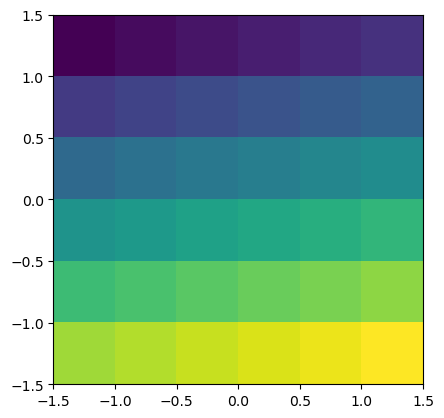

In [62]:
show(elev, transform=new_transform);

The `grain` raster can be plotted the same way, as we are going to use the same transformation matrix for it as well:

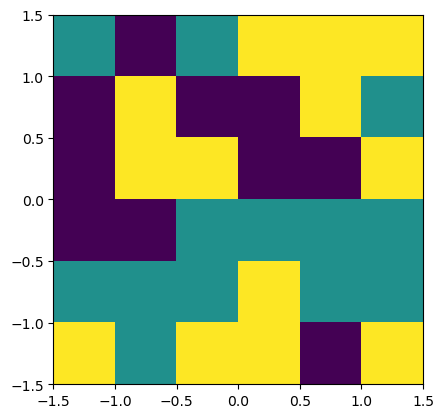

In [66]:
show(grain, transform=new_transform);

At this point, we can work with the raster using `rasterio`:

* Passing the transformation matrix wherever true raster pixel coordinates are important (such as in function `show` above)
* Keeping in mind that any other layer we use in the analysis is in the same CRS of those coordinates

Finally, to export the raster for permanent storage, along with the CRS definition, we need to go through the following steps:

* Create a raster file connection (where we set the transform and the CRS, among other settings)
* Write the array with raster values into the connection
* Close the connection

In the case of `elev`, we do it as follows:


In [64]:
new_dataset = rasterio.open(
    'output/elev.tif', 'w', 
    driver = 'GTiff',
    height = elev.shape[0],
    width = elev.shape[1],
    count = 1,
    dtype = elev.dtype,
    crs = 4326,
    transform = new_transform
)
new_dataset.write(elev, 1)
new_dataset.close()

Note that the CRS we (arbitrarily) set for the `elev` raster is WGS84, defined using `crs=4326` according to the EPSG code.

Here is how we export the `grain` raster as well, using almost the exact same code section just with `elev` replaced with `grain`:

In [65]:
new_dataset = rasterio.open(
    'output/grain.tif', 'w', 
    driver = 'GTiff',
    height = grain.shape[0],
    width = grain.shape[1],
    count = 1,
    dtype = grain.dtype,
    crs = 4326,
    transform = new_transform
)
new_dataset.write(grain, 1)
new_dataset.close()

Don't worry if the raster export code is unclear. We will elaborate on the details of raster output in @read-write.

Note that the transform matrices and dimensions of `elev` and `grain` are identical. This means that the rasters are overlapping, and can be combined into one two-band raster, combined in raster algebra operations (@sec-map-algebra), etc.

## Coordinate Reference Systems

Vector and raster spatial data types share concepts intrinsic to spatial data. 
Perhaps the most fundamental of these is the Coordinate Reference System (CRS), which defines how the spatial elements of the data relate to the surface of the Earth (or other bodies).
CRSs are either geographic or projected, as introduced at the beginning of this chapter (see ...).
This section explains each type, laying the foundations for Chapter 7, which provides a deep dive into setting, transforming, and querying CRSs.

### Geographic coordinate systems

Geographic coordinate systems identify any location on the Earth's surface using two values — longitude and latitude (see left panel of Figure ...). Longitude is a location in the East-West direction in angular distance from the Prime Meridian plane, while latitude is an angular distance North or South of the equatorial plane.
Distances in geographic CRSs are therefore not measured in meters. 
This has important consequences, as demonstrated in Section 7.

A spherical or ellipsoidal surface represents the surface of the Earth in geographic coordinate systems. 
Spherical models assume that the Earth is a perfect sphere of a given radius — they have the advantage of simplicity, but, at the same time, they are inaccurate: the Earth is not a sphere!
Ellipsoidal models are defined by two parameters: the equatorial radius and the polar radius. 
These are suitable because the Earth is compressed: the equatorial radius is around 11.5 km longer than the polar radius.
<!-- TODO: add reference, (Maling 1992...). -->

Ellipsoids are part of a broader component of CRSs: the datum. 
This contains information on what ellipsoid to use and the precise relationship between the Cartesian coordinates and location on the Earth's surface.
There are two types of datum — geocentric (such as WGS84) and local (such as NAD83). 
You can see examples of these two types of datums in Figure .... 
Black lines represent a geocentric datum, whose center is located in the Earth's center of gravity and is not optimized for a specific location.
In a local datum, shown as a purple dashed line, the ellipsoidal surface is shifted to align with the surface at a particular location. 
These allow local variations on Earth's surface, such as large mountain ranges, to be accounted for in a local CRS. 
<!-- This can be seen in Figure ..., where the local datum is fitted to the area of Philippines, but is misaligned with most of the rest of the planet's surface. Both datums in Figure ... are put on top of a geoid - a model of global mean sea level. -->

### Projected coordinate reference systems

All projected CRSs are based on a geographic CRS, described in the previous section, and rely on map projections to convert the three-dimensional surface of the Earth into Easting and Northing (x and y) values in a projected CRS.
Projected CRSs are based on Cartesian coordinates on an implicitly flat surface.
 <!-- TODO (right panel of Figure ...).  -->
They have an origin, x and y axes, and a linear unit of measurement such as meters.

This transition cannot be done without adding some deformations. 
Therefore, some properties of the Earth's surface are distorted in this process, such as area, direction, distance, and shape. 
A projected coordinate system can preserve only one or two of those properties.
Projections are often named based on a property they preserve: equal-area preserves area, azimuthal preserves direction, equidistant preserves distance, and conformal preserves local shape.

There are three main groups of projection types: conic, cylindrical, and planar (azimuthal). 
In a conic projection, the Earth's surface is projected onto a cone along a single line of tangency or two lines of tangency.
Distortions are minimized along the tangency lines and rise with the distance from those lines in this projection.
Therefore, it is best suited for maps of mid-latitude areas. 
A cylindrical projection maps the surface onto a cylinder.
This projection could also be created by touching the Earth's surface along a single line of tangency or two lines of tangency.
Cylindrical projections are used most often when mapping the entire world. 
A planar projection projects data onto a flat surface touching the globe at a point or along a line of tangency.
It is typically used in mapping polar regions. 

Like most open-source geospatial software, the **geopandas** and **rasterio** packages use the PROJ software for CRS definition and calculations. 
The **pyproj** package is a low-level interface to PROJ. 
Using its functions, we can examine the list of supported projections:

In [ ]:
import pyproj
epsg_codes = pyproj.get_codes('EPSG', 'CRS')  ## List of supported EPSG codes
epsg_codes[:5]  ## print first five

In [ ]:
pyproj.CRS.from_epsg(4326)  ## Printout of WGS84 CRS (EPSG:4326)

A quick summary of different projections, their types, properties, and suitability can be found in “Map Projections” (1993) and at <https://www.geo-projections.com/>.
We will expand on CRSs and explain how to project from one CRS to another in Chapter 7. 
But, for now, it is sufficient to know:

* That coordinate systems are a key component of geographic objects
* Knowing which CRS your data is in, and whether it is in geographic (lon/lat) or projected (typically meters), is important and has consequences for how Python handles spatial and geometry operations
* CRSs of **geopandas** (vector layer or geometry column) and **rasterio** (raster) objects can be queried with the `.crs` property

Here is a demonstration of the last bullet point:

In [ ]:
gdf.crs

In [ ]:
src.crs

## Units

An essential feature of CRSs is that they contain information about spatial units.
Clearly, it is vital to know whether a house's measurements are in feet or meters, and the same applies to maps.
It is a good cartographic practice to add a scale bar or some other distance indicator onto maps to demonstrate the relationship between distances on the page or screen and distances on the ground. 
Likewise, it is important for the user to be aware of the units in which the geometry coordinates are, to ensure that subsequent calculations are done in the right context.

Python spatial data structures in **geopandas** and **rasterio** do not natively support the concept of measurement.
The coordinates of a vector layer or a raster are plain numbers, referring to an arbitrary plane.
For example, according to the `.transform` matrix of `srtm.tif` we can see that the raster resolution is `0.000833` and that its CRS is WGS84 (EPSG: `4326`). 
We may know (or can find out) that the units of WGS84 are decimal degrees. 
However, that information is not encoded in any numeric calculation.

In [ ]:
src.meta

Consequently, we need to be aware of the CRS units we are working with. Typically, these are decimal degrees, in a geographic CRS, or $m$, in a projected CRS, although there are exceptions.
Geometric calculations such as length, area, or distance, return plain numbers in the same units of the CRS (such as $m$ or $m^2$). 
It is up to the user to determine which units the result is given in and treat the result accordingly. 
For example, if the area output was in $m^2$ and we need the result in $km^2$, then we need to divide the result by $1000^2$. 

## Exercises

...
